# ABC-SMC

This example shows you how to perform ABC Sequential Monte Carlo on a time series from the stochastic degradation model.

First we generate some data using the suggested parameters for this model.

In [28]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load forward model
model = toy.StochasticDegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 50, 100)
values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior(
    [0.0],
    [0.3]
)

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)


We can visualize the generated data against the expected data below

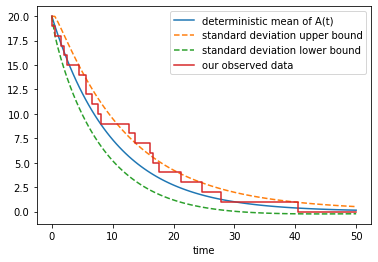

In [29]:
mean = model.mean(real_parameters, times)
variance = model.variance(real_parameters, times)
std_dev = np.sqrt(variance)

plt.plot(times, mean, '-', label = 'deterministic mean of A(t)')
plt.plot(times, mean + std_dev, '--', label = 'standard deviation upper bound')
plt.plot(times, mean - std_dev, '--', label = 'standard deviation lower bound')

plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

We now create a Sequential ABC Controller, this takes a number of optional parameters but left as default it will carry out the Toni 2019 ABC-SMC sampling algorithm

In [30]:
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

In [31]:
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([3,1.5,1]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_nr_samples(200)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=1.5
Trying t=2, threshold=1.0
Iter. Eval. Acceptance rate Time m:s
1     1543   0.00064808814    0:05.1
2     1558   0.00128369705    0:05.1
3     1569   0.00191204589    0:05.1
20    1862   0.0107411386     0:05.8
40    2330   0.017167382      0:06.5
60    2623   0.0228745711     0:06.9
80    3022   0.0264725347     0:07.5
100   3328   0.0300480769     0:08.2
120   3749   0.0320085356     0:08.6
140   4442   0.0315173345     0:09.9
160   4812   0.0332502078     0:10.6
180   5128   0.0351014041     0:11.1
200   5828   0.0343170899     0:12.0
Halting: target number of samples (200) reached.
Done


We can then see how our series of intermediate distributions did at approximating the actual parameters by plotting them as histograms

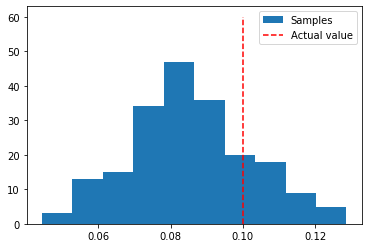

In [32]:
plt.hist([x[0] for x in samples], label='Samples')

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=60, label='Actual value', color='red')
plt.legend()
plt.show()

## Now we can compare the recovered parameters to the real parameters used to generate this data

observed params: [0.0837292]
actual params: [0.1]


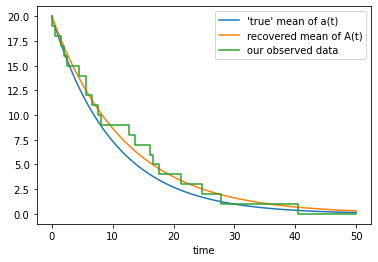

In [33]:
import statistics

observed_k = statistics.median(samples)
print("observed params: " + str(observed_k))
print("actual params: " + str(model.suggested_parameters()))

observed_mean = model.mean(observed_k, times)
true_mean = model.mean(model.suggested_parameters(),times)
plt.plot(times, true_mean, '-', label = "'true' mean of a(t)")
plt.plot(times, observed_mean, '-', label = 'recovered mean of A(t)')
plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

Compare this to using normal ABC-Rejection

In [34]:
abc = pints.ABCController(error_measure, log_prior, pints.RejectionABC)

# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_nr_samples(200)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print('Done!')

Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     30     0.0333333333     0:00.1
2     100    0.02             0:00.2
3     118    0.0254237288     0:00.3
20    1083   0.0184672207     0:01.5
40    1919   0.0208441897     0:02.3
60    3004   0.0199733688     0:03.5
80    3947   0.0202685584     0:04.4
100   4929   0.0202880909     0:05.4
120   5923   0.0202600034     0:06.4
140   7287   0.0192122959     0:08.0
160   8603   0.0185981634     0:09.1
180   9354   0.0192431046     0:09.7
200   10506  0.0190367409     0:11.0
Halting: target number of samples (200) reached.
Done!


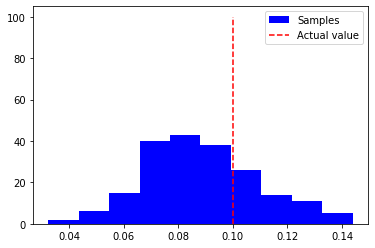

In [35]:
plt.hist(samples[:,0], color="blue", label='Samples')
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=100, color='red', label='Actual value')
plt.legend()
plt.show()